# Chronic Kidney Disease — Fixed & Complete ML Pipeline

**Fixes applied:**
1. ✅ Data leakage fixed: Imputer fit **only on train set**
2. ✅ Pipeline order enforced: `Split → Impute → SMOTE → Scale → Select`
3. ✅ Chi-Square shift applied correctly on non-negative data
4. ✅ Ensemble label corrected: **SVM + HistGB + GB** (not RF)
5. ✅ CSV results actually saved at end

**Pipeline Steps:**
1. Load & Explore Datasets
2. Harmonize & Merge
3. Clean Target
4. Stratified Train/Test Split (80/20) ← **Split first!**
5. Median Imputation (train-only fit)
6. SMOTE Oversampling (training only)
7. Feature Scaling (train-only fit)
8. Ensemble Feature Selection (Chi2 + MI + RFE)
9. 10-Fold Stratified Cross-Validation
10. Test Set Evaluation (7 Classifiers)
11. Soft Voting Ensemble (SVM + HistGB + GB)
12. Confusion Matrices
13. Model Comparison Plot
14. SHAP Explainability
15. Save All Results

In [8]:
# ─────────────────────────────────────────────
# 1. IMPORTS
# ─────────────────────────────────────────────
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     cross_validate)
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import (chi2, mutual_info_classif,
                                       SelectKBest, RFE)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                               GradientBoostingClassifier,
                               HistGradientBoostingClassifier,
                               VotingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                              classification_report, confusion_matrix,
                              ConfusionMatrixDisplay)
from statsmodels.stats.proportion import proportion_confint
import shap

print('=' * 65)
print('  CHRONIC KIDNEY DISEASE — ML PIPELINE (FIXED)')
print('=' * 65)
print('✅ All libraries imported\n')

  CHRONIC KIDNEY DISEASE — ML PIPELINE (FIXED)
✅ All libraries imported



In [9]:
# ─────────────────────────────────────────────
# 2. LOAD DATASETS
# ─────────────────────────────────────────────
print('STEP 1: LOADING DATASETS')
print('-' * 45)

df1 = pd.read_csv('/chronic_kidney_disease.csv')
df1.columns = df1.columns.str.strip()
df1.replace('?', np.nan, inplace=True)
print(f'Dataset 1 (UCI CKD)      shape: {df1.shape}')

df2 = pd.read_csv('/Chronic_Kidney_Dsease_data.csv')
print(f'Dataset 2 (Extended CKD) shape: {df2.shape}\n')

df1.head()

STEP 1: LOADING DATASETS
---------------------------------------------
Dataset 1 (UCI CKD)      shape: (400, 25)
Dataset 2 (Extended CKD) shape: (1659, 54)



,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [10]:
# ─────────────────────────────────────────────
# 3. HARMONIZE & MERGE
# ─────────────────────────────────────────────
print('STEP 2: HARMONIZE & MERGE')
print('-' * 45)

# ── UCI Dataset ──
d1 = df1.copy()
d1['class'] = d1['class'].str.strip().str.replace('\t', '')
d1['target'] = d1['class'].map({'ckd': 1, 'notckd': 0})
d1.drop(columns=['class'], inplace=True)

uci_num = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc',
           'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
uci_cat = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

le = LabelEncoder()
for col in uci_cat:
    if col in d1.columns:
        mask = d1[col].notna() & (d1[col].astype(str) != 'nan')
        vals = d1.loc[mask, col].astype(str)
        if len(vals) > 0:
            le.fit(vals)
            d1.loc[mask, col] = le.transform(vals)
            d1.loc[~mask, col] = np.nan

for col in uci_num:
    if col in d1.columns:
        d1[col] = pd.to_numeric(d1[col], errors='coerce')

d1_fin = d1[uci_num + uci_cat + ['target']].copy()
d1_fin['_src'] = 'uci'

# ── Extended Dataset ──
d2 = df2.copy()
d2_sel = pd.DataFrame()
d2_sel['age']    = d2['Age']
d2_sel['bp']     = d2['SystolicBP']
d2_sel['sc']     = d2['SerumCreatinine']
d2_sel['bu']     = d2['BUNLevels']
d2_sel['hemo']   = d2['HemoglobinLevels']
d2_sel['sod']    = d2['SerumElectrolytesSodium']
d2_sel['pot']    = d2['SerumElectrolytesPotassium']
d2_sel['bgr']    = d2['FastingBloodSugar']
d2_sel['htn']    = d2['FamilyHistoryHypertension'].astype(float)
d2_sel['dm']     = d2['FamilyHistoryDiabetes'].astype(float)
d2_sel['target'] = d2['Diagnosis'].astype(int)
d2_sel['_src']   = 'ext'

for col in d1_fin.columns:
    if col not in d2_sel.columns:
        d2_sel[col] = np.nan

# ── Merge ──
merged = pd.concat([d1_fin, d2_sel], ignore_index=True, sort=False)
merged.drop(columns=['_src'], inplace=True)
merged.to_csv('merged_ckd_dataset.csv', index=False)

print(f'✅ Merged shape : {merged.shape}')
print(f'   CKD     (1) : {(merged["target"] == 1).sum()}')
print(f'   Not CKD (0) : {(merged["target"] == 0).sum()}')
print('💾 Saved : merged_ckd_dataset.csv\n')

merged.head()

STEP 2: HARMONIZE & MERGE
---------------------------------------------
✅ Merged shape : (2059, 25)
   CKD     (1) : 1774
   Not CKD (0) : 284
💾 Saved : merged_ckd_dataset.csv



,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,target
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,1,0,0,1,1,0,0,1,0,1.0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,1,0,0,0,0,0,0,1,0,1.0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,1,0,0,0,1,0,2,1,1,1.0
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,0,1,0,1,0,0,2,2,1,1.0
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,1,0,0,0,0,0,0,1,0,1.0


In [11]:
# ─────────────────────────────────────────────
# 4. CLEAN TARGET
# ─────────────────────────────────────────────
print('STEP 3: CLEAN TARGET')
print('-' * 45)

merged_clean = merged.dropna(subset=['target'])
X_raw = merged_clean.drop(columns=['target'])
y = merged_clean['target'].astype(int)

print(f'Rows dropped (NaN target): {len(merged) - len(merged_clean)}')
print(f'Total records : {len(merged_clean)}  |  Features : {X_raw.shape[1]}')
print(f'Class distribution:\n{y.value_counts()}\n')

STEP 3: CLEAN TARGET
---------------------------------------------
Rows dropped (NaN target): 1
Total records : 2058  |  Features : 24
Class distribution:
target
1    1774
0     284
Name: count, dtype: int64



In [12]:
# ─────────────────────────────────────────────
# 5. STRATIFIED TRAIN/TEST SPLIT 80/20
# FIX: Split FIRST before any fitting (prevents data leakage)
# ─────────────────────────────────────────────
print('STEP 4: STRATIFIED TRAIN/TEST SPLIT (80/20)')
print('-' * 45)

X_tr_raw, X_te_raw, y_tr, y_te = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=y)

print(f'Train : {X_tr_raw.shape[0]}  |  Test : {X_te_raw.shape[0]}')
print(f'Train class dist : {dict(y_tr.value_counts().sort_index())}')
print(f'Test  class dist : {dict(y_te.value_counts().sort_index())}\n')

STEP 4: STRATIFIED TRAIN/TEST SPLIT (80/20)
---------------------------------------------
Train : 1646  |  Test : 412
Train class dist : {0: np.int64(227), 1: np.int64(1419)}
Test  class dist : {0: np.int64(57), 1: np.int64(355)}



In [13]:
# ─────────────────────────────────────────────
# 6. MEDIAN IMPUTATION
# FIX: Imputer fit ONLY on train set, then transform test
# (Original code fit on entire dataset BEFORE split — data leakage!)
# ─────────────────────────────────────────────
print('STEP 5: MEDIAN IMPUTATION (train-only fit)')
print('-' * 45)

imp = SimpleImputer(strategy='median')
X_tr_imp = pd.DataFrame(imp.fit_transform(X_tr_raw), columns=X_tr_raw.columns)  # fit on train only
X_te_imp = pd.DataFrame(imp.transform(X_te_raw),     columns=X_te_raw.columns)  # transform test only

print(f'Train missing after imputation : {X_tr_imp.isnull().sum().sum()}')
print(f'Test  missing after imputation : {X_te_imp.isnull().sum().sum()}\n')

STEP 5: MEDIAN IMPUTATION (train-only fit)
---------------------------------------------
Train missing after imputation : 0
Test  missing after imputation : 0



In [14]:
# ─────────────────────────────────────────────
# 7. SMOTE OVERSAMPLING (Training only)
# ─────────────────────────────────────────────
print('STEP 6: SMOTE OVERSAMPLING (train only)')
print('-' * 45)

X_tr_res, y_tr_res = SMOTE(random_state=42).fit_resample(X_tr_imp, y_tr)
print(f'After SMOTE → {X_tr_res.shape[0]} samples')
print(f'Class dist : {dict(pd.Series(y_tr_res).value_counts().sort_index())}\n')

STEP 6: SMOTE OVERSAMPLING (train only)
---------------------------------------------
After SMOTE → 2838 samples
Class dist : {0: np.int64(1419), 1: np.int64(1419)}



In [15]:
# ─────────────────────────────────────────────
# 8. FEATURE SCALING
# Scaler fit ONLY on SMOTE train set
# ─────────────────────────────────────────────
print('STEP 7: FEATURE SCALING (train-only fit)')
print('-' * 45)

sc_scaler = StandardScaler()
X_tr_sc = pd.DataFrame(sc_scaler.fit_transform(X_tr_res), columns=X_tr_res.columns)
X_te_sc  = pd.DataFrame(sc_scaler.transform(X_te_imp),    columns=X_te_imp.columns)

print('✅ StandardScaler applied\n')

STEP 7: FEATURE SCALING (train-only fit)
---------------------------------------------
✅ StandardScaler applied



STEP 8: ENSEMBLE FEATURE SELECTION (Chi2 + MI + RFE)
---------------------------------------------
Chi-Square  (11) : [np.str_('al'), np.str_('ane'), np.str_('appet'), np.str_('bp'), np.str_('cad'), np.str_('dm'), np.str_('htn'), np.str_('pcc'), np.str_('pe'), np.str_('sc'), np.str_('su')]
Mutual Info (11)  : [np.str_('age'), np.str_('bgr'), np.str_('bp'), np.str_('dm'), np.str_('htn'), np.str_('pcv'), np.str_('rbcc'), np.str_('sc'), np.str_('sg'), np.str_('sod'), np.str_('wbcc')]
RFE         (11) : [np.str_('al'), np.str_('appet'), np.str_('bgr'), np.str_('bp'), np.str_('bu'), np.str_('pcv'), np.str_('pe'), np.str_('rbcc'), np.str_('sc'), np.str_('sg'), np.str_('su')]

✅ Consensus (12) : ['al', 'appet', 'bgr', 'bp', 'dm', 'htn', 'pcv', 'pe', 'rbcc', 'sc', 'sg', 'su']



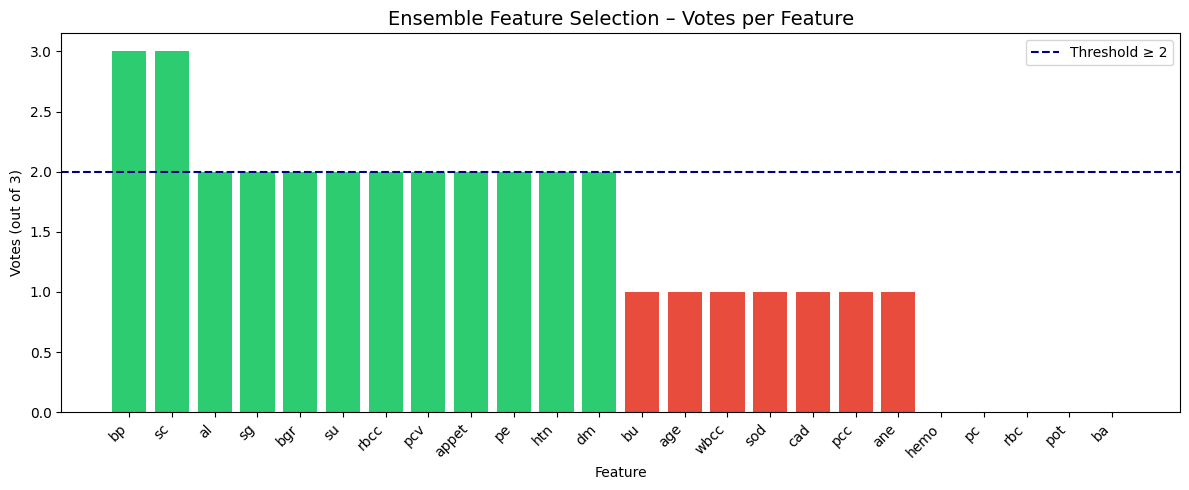

📊 Saved: feature_selection_votes.png


In [16]:
# ─────────────────────────────────────────────
# 9. ENSEMBLE FEATURE SELECTION
# FIX: Chi2 shift correctly applied to ensure non-negative values
# FIX: All selection done on train set only
# ─────────────────────────────────────────────
print('STEP 8: ENSEMBLE FEATURE SELECTION (Chi2 + MI + RFE)')
print('-' * 45)

feats = X_tr_sc.columns.tolist()
k = min(11, len(feats))

# Chi-Square: requires non-negative values → shift by column min
X_tr_shifted = X_tr_sc - X_tr_sc.min()  # all values >= 0
chi2_sel = SelectKBest(chi2, k=k)
chi2_sel.fit(X_tr_shifted, y_tr_res)
chi2_f = set(np.array(feats)[chi2_sel.get_support()])

# Mutual Information
mi_sc = mutual_info_classif(X_tr_sc, y_tr_res, random_state=42)
mi_f  = set(np.array(feats)[np.argsort(mi_sc)[::-1][:k]])

# RFE with Logistic Regression
rfe_sel = RFE(LogisticRegression(max_iter=1000, random_state=42),
              n_features_to_select=k)
rfe_sel.fit(X_tr_sc, y_tr_res)
rfe_f = set(np.array(feats)[rfe_sel.support_])

# Consensus: feature selected by at least 2 out of 3 methods
votes   = {f: sum([f in chi2_f, f in mi_f, f in rfe_f]) for f in feats}
consens = [f for f, v in votes.items() if v >= 2]

print(f'Chi-Square  ({len(chi2_f)}) : {sorted(chi2_f)}')
print(f'Mutual Info ({len(mi_f)})  : {sorted(mi_f)}')
print(f'RFE         ({len(rfe_f)}) : {sorted(rfe_f)}')
print(f'\n✅ Consensus ({len(consens)}) : {sorted(consens)}\n')

X_tr_sel = X_tr_sc[consens]
X_te_sel  = X_te_sc[consens]

# Plot votes
plt.figure(figsize=(12, 5))
vs = pd.Series(votes).sort_values(ascending=False)
plt.bar(vs.index, vs.values,
        color=['#2ecc71' if v >= 2 else '#e74c3c' for v in vs.values])
plt.axhline(2, color='navy', ls='--', lw=1.5, label='Threshold ≥ 2')
plt.title('Ensemble Feature Selection – Votes per Feature', fontsize=14)
plt.xlabel('Feature')
plt.ylabel('Votes (out of 3)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('feature_selection_votes.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: feature_selection_votes.png')

In [17]:
# ─────────────────────────────────────────────
# 10. 10-FOLD STRATIFIED CROSS-VALIDATION
# ─────────────────────────────────────────────
print('STEP 9: 10-FOLD STRATIFIED CROSS-VALIDATION')
print('-' * 45)

models = {
    'Decision Tree':          DecisionTreeClassifier(random_state=42),
    'Random Forest':          RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting':      GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(random_state=42),
    'SVM':                    SVC(probability=True, random_state=42),
    'KNN':                    KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression':    LogisticRegression(max_iter=1000, random_state=42),
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_res = {}

for nm, clf in models.items():
    cv = cross_validate(clf, X_tr_sel, y_tr_res, cv=skf,
                        scoring=['accuracy', 'f1', 'roc_auc'])
    cv_res[nm] = {
        'CV Accuracy': round(cv['test_accuracy'].mean(), 4),
        'CV F1':       round(cv['test_f1'].mean(), 4),
        'CV AUC-ROC':  round(cv['test_roc_auc'].mean(), 4),
    }
    print(f'  {nm:28s}| Acc:{cv_res[nm]["CV Accuracy"]:.4f} '
          f'| F1:{cv_res[nm]["CV F1"]:.4f} '
          f'| AUC:{cv_res[nm]["CV AUC-ROC"]:.4f}')

cv_df = pd.DataFrame(cv_res).T
cv_df

STEP 9: 10-FOLD STRATIFIED CROSS-VALIDATION
---------------------------------------------
  Decision Tree               | Acc:0.8953 | F1:0.8943 | AUC:0.8953
  Random Forest               | Acc:0.9271 | F1:0.9280 | AUC:0.9778
  Gradient Boosting           | Acc:0.8999 | F1:0.9040 | AUC:0.9650
  Hist Gradient Boosting      | Acc:0.9200 | F1:0.9208 | AUC:0.9748
  SVM                         | Acc:0.8735 | F1:0.8823 | AUC:0.9450
  KNN                         | Acc:0.8862 | F1:0.8852 | AUC:0.9591
  Logistic Regression         | Acc:0.8111 | F1:0.8195 | AUC:0.9002


,CV Accuracy,CV F1,CV AUC-ROC
Decision Tree,0.8953,0.8943,0.8953
Random Forest,0.9271,0.9280,0.9778
Gradient Boosting,0.8999,0.9040,0.9650
Hist Gradient Boosting,0.9200,0.9208,0.9748
SVM,0.8735,0.8823,0.9450
KNN,0.8862,0.8852,0.9591
Logistic Regression,0.8111,0.8195,0.9002


In [18]:
# ─────────────────────────────────────────────
# 11. TEST SET EVALUATION
# ─────────────────────────────────────────────
print('STEP 10: TEST SET EVALUATION')
print('-' * 45)

te_res  = {}
trained = {}

for nm, clf in models.items():
    clf.fit(X_tr_sel, y_tr_res)
    trained[nm] = clf
    yp   = clf.predict(X_te_sel)
    yprb = clf.predict_proba(X_te_sel)[:, 1]

    acc = accuracy_score(y_te, yp)
    f1  = f1_score(y_te, yp)
    auc = roc_auc_score(y_te, yprb)
    te_res[nm] = {'Test Accuracy': acc, 'Test F1': f1, 'Test AUC-ROC': auc}
    print(f'  {nm:28s}| Acc:{acc:.4f} | F1:{f1:.4f} | AUC:{auc:.4f}')

te_df = pd.DataFrame(te_res).T

best_nm = te_df['Test Accuracy'].idxmax()
best_ac = te_df.loc[best_nm, 'Test Accuracy']
nc      = int(round(best_ac * len(y_te)))
ci_l, ci_h = proportion_confint(nc, len(y_te), method='wilson')
print(f'\n✅ Best Individual Model: {best_nm} | Acc:{best_ac:.4f} | 95% CI:[{ci_l:.3f},{ci_h:.3f}]\n')

te_df

STEP 10: TEST SET EVALUATION
---------------------------------------------
  Decision Tree               | Acc:0.8762 | F1:0.9268 | AUC:0.7883
  Random Forest               | Acc:0.8981 | F1:0.9412 | AUC:0.8718
  Gradient Boosting           | Acc:0.9078 | F1:0.9471 | AUC:0.8743
  Hist Gradient Boosting      | Acc:0.8859 | F1:0.9337 | AUC:0.8627
  SVM                         | Acc:0.9126 | F1:0.9497 | AUC:0.8620
  KNN                         | Acc:0.8519 | F1:0.9112 | AUC:0.8079
  Logistic Regression         | Acc:0.8374 | F1:0.9007 | AUC:0.8782

✅ Best Individual Model: SVM | Acc:0.9126 | 95% CI:[0.881,0.936]



,Test Accuracy,Test F1,Test AUC-ROC
Decision Tree,0.876214,0.926829,0.788263
Random Forest,0.898058,0.941176,0.871806
Gradient Boosting,0.907767,0.947075,0.874253
Hist Gradient Boosting,0.885922,0.933709,0.862713
SVM,0.912621,0.949721,0.861972
KNN,0.851942,0.911208,0.807882
Logistic Regression,0.837379,0.900741,0.878181


In [19]:
# ─────────────────────────────────────────────
# 12. SOFT VOTING ENSEMBLE
# FIX: Label corrected — SVM + HistGB + GB (not RF + HistGB + GB)
# ─────────────────────────────────────────────
print('STEP 11: SOFT VOTING ENSEMBLE (SVM + HistGB + GB)')
print('-' * 45)

ens = VotingClassifier(estimators=[
    ('SVM', SVC(probability=True, random_state=42)),
    ('HGB', HistGradientBoostingClassifier(random_state=42)),
    ('GB',  GradientBoostingClassifier(n_estimators=100, random_state=42)),
], voting='soft')

ens.fit(X_tr_sel, y_tr_res)
yp_e  = ens.predict(X_te_sel)
ypr_e = ens.predict_proba(X_te_sel)[:, 1]

ea = accuracy_score(y_te, yp_e)
ef = f1_score(y_te, yp_e)
eu = roc_auc_score(y_te, ypr_e)

print(f'  Ensemble | Acc:{ea:.4f} | F1:{ef:.4f} | AUC:{eu:.4f}')
print('\nClassification Report:')
print(classification_report(y_te, yp_e, target_names=['Not CKD', 'CKD']))

STEP 11: SOFT VOTING ENSEMBLE (SVM + HistGB + GB)
---------------------------------------------
  Ensemble | Acc:0.9150 | F1:0.9513 | AUC:0.8722

Classification Report:
              precision    recall  f1-score   support

     Not CKD       0.73      0.61      0.67        57
         CKD       0.94      0.96      0.95       355

    accuracy                           0.92       412
   macro avg       0.83      0.79      0.81       412
weighted avg       0.91      0.92      0.91       412



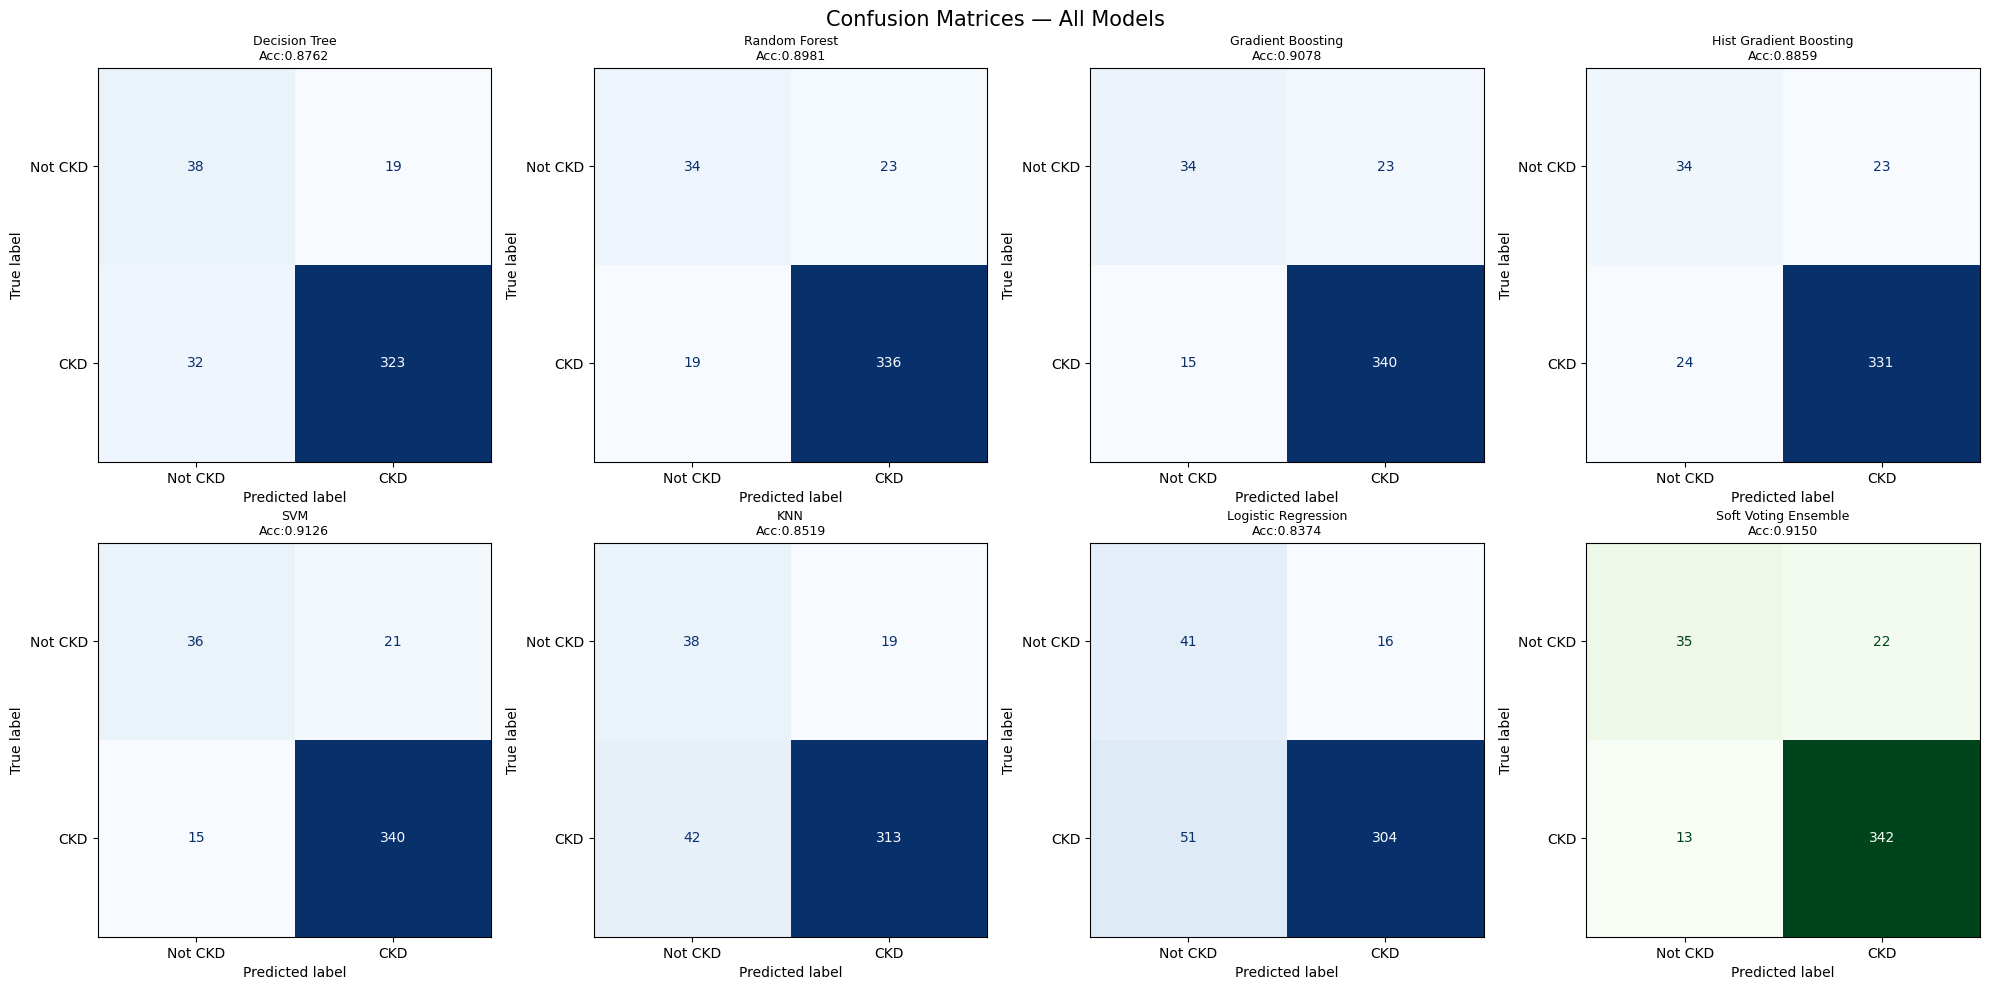

📊 Saved: confusion_matrices.png


In [20]:
# ─────────────────────────────────────────────
# 13. CONFUSION MATRICES
# ─────────────────────────────────────────────
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
ax = axes.flatten()

for i, (nm, clf) in enumerate(trained.items()):
    yp = clf.predict(X_te_sel)
    ConfusionMatrixDisplay(confusion_matrix(y_te, yp),
                           display_labels=['Not CKD', 'CKD']).plot(
        ax=ax[i], colorbar=False, cmap='Blues')
    ax[i].set_title(f'{nm}\nAcc:{accuracy_score(y_te, yp):.4f}', fontsize=9)

ConfusionMatrixDisplay(confusion_matrix(y_te, yp_e),
                       display_labels=['Not CKD', 'CKD']).plot(
    ax=ax[7], colorbar=False, cmap='Greens')
ax[7].set_title(f'Soft Voting Ensemble\nAcc:{ea:.4f}', fontsize=9)

plt.suptitle('Confusion Matrices — All Models', fontsize=15)
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: confusion_matrices.png')

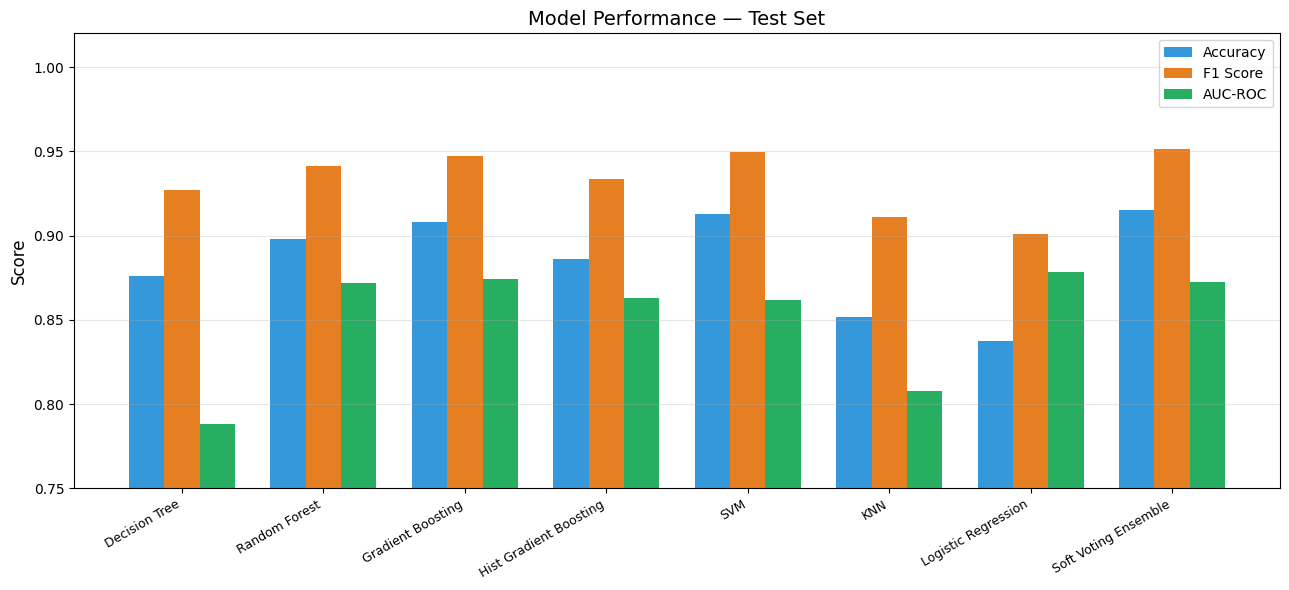

📊 Saved: model_comparison.png


In [21]:
# ─────────────────────────────────────────────
# 14. MODEL COMPARISON PLOT
# ─────────────────────────────────────────────
all_r = te_df.copy()
all_r.loc['Soft Voting Ensemble'] = [ea, ef, eu]

fig, ax = plt.subplots(figsize=(13, 6))
x = np.arange(len(all_r))
w = 0.25
ax.bar(x - w, all_r['Test Accuracy'], w, label='Accuracy',  color='#3498db')
ax.bar(x,     all_r['Test F1'],       w, label='F1 Score',  color='#e67e22')
ax.bar(x + w, all_r['Test AUC-ROC'],  w, label='AUC-ROC',   color='#27ae60')
ax.set_xticks(x)
ax.set_xticklabels(all_r.index, rotation=30, ha='right', fontsize=9)
ax.set_ylim(0.75, 1.02)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance — Test Set', fontsize=14)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: model_comparison.png')

STEP 14: SHAP EXPLAINABILITY
---------------------------------------------


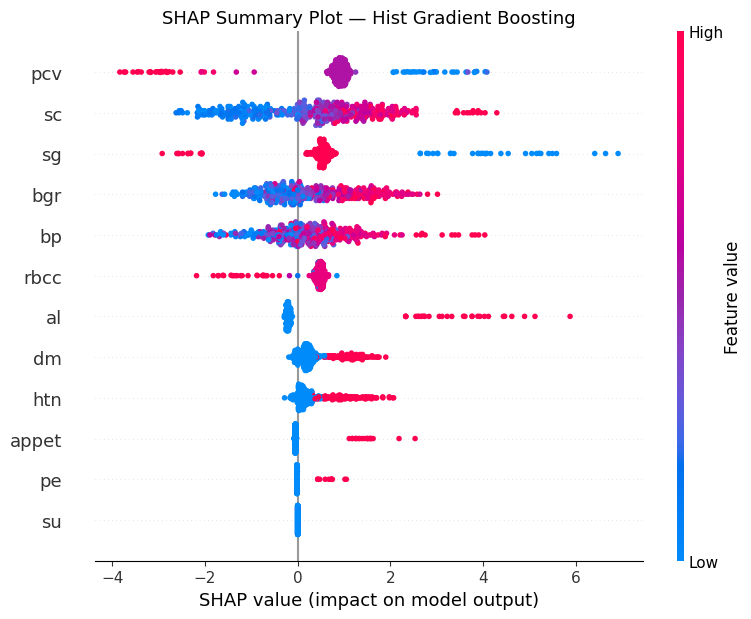

📊 Saved: shap_summary.png


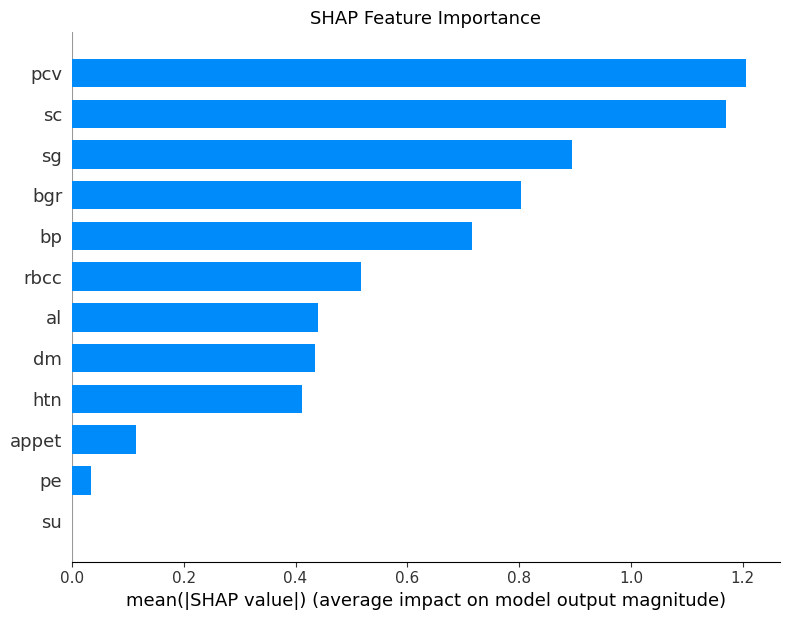

📊 Saved: shap_bar.png

Top Features by SHAP:
Feature  Mean |SHAP|
    pcv     1.206412
     sc     1.170277
     sg     0.895067
    bgr     0.803858
     bp     0.716205
   rbcc     0.517919
     al     0.440969
     dm     0.434081
    htn     0.412209
  appet     0.114397
     pe     0.034565
     su     0.000000


In [22]:
# ─────────────────────────────────────────────
# 15. SHAP EXPLAINABILITY
# ─────────────────────────────────────────────
print('STEP 14: SHAP EXPLAINABILITY')
print('-' * 45)

explainer = shap.TreeExplainer(trained['Hist Gradient Boosting'])
sv = explainer.shap_values(X_te_sel)

if isinstance(sv, list):
    sv = sv[1]
elif hasattr(sv, 'ndim') and sv.ndim == 3:
    sv = sv[:, :, 1]

fl = list(consens)

# Beeswarm plot
plt.figure(figsize=(10, 6))
shap.summary_plot(sv, X_te_sel, feature_names=fl, show=False, plot_type='dot')
plt.title('SHAP Summary Plot — Hist Gradient Boosting', fontsize=13)
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: shap_summary.png')

# Bar plot
plt.figure(figsize=(9, 5))
shap.summary_plot(sv, X_te_sel, feature_names=fl, show=False, plot_type='bar')
plt.title('SHAP Feature Importance', fontsize=13)
plt.tight_layout()
plt.savefig('shap_bar.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: shap_bar.png')

shap_imp = pd.DataFrame({
    'Feature':     fl,
    'Mean |SHAP|': np.abs(sv).mean(axis=0)
}).sort_values('Mean |SHAP|', ascending=False)

print('\nTop Features by SHAP:')
print(shap_imp.to_string(index=False))

In [23]:
# ─────────────────────────────────────────────
# 16. SAVE ALL RESULTS TO CSV
# FIX: Was missing in original notebook — now properly saved
# ─────────────────────────────────────────────
print('STEP 15: SAVING ALL RESULTS')
print('-' * 45)

cv_df.to_csv('cv_results.csv')
print('💾 Saved: cv_results.csv')

all_r.round(4).to_csv('test_results.csv')
print('💾 Saved: test_results.csv')

shap_imp.to_csv('shap_importance.csv', index=False)
print('💾 Saved: shap_importance.csv')

STEP 15: SAVING ALL RESULTS
---------------------------------------------
💾 Saved: cv_results.csv
💾 Saved: test_results.csv
💾 Saved: shap_importance.csv


In [24]:
# ─────────────────────────────────────────────
# FINAL SUMMARY
# ─────────────────────────────────────────────
print('\n' + '=' * 65)
print('  FINAL SUMMARY')
print('=' * 65)

print('\n📋 Cross-Validation Results:')
print(cv_df.to_string())

print('\n📋 Test Set Results:')
print(all_r.round(4).to_string())

print(f'\n🏆 Best Individual Model : {best_nm}')
print(f'   Accuracy             : {best_ac:.4f} | 95% CI:[{ci_l:.3f},{ci_h:.3f}]')

print(f'\n🏆 Soft Voting Ensemble (SVM + HistGB + GB)')
print(f'   Acc:{ea:.4f} | F1:{ef:.4f} | AUC:{eu:.4f}')

print(f'\n🔑 Top-5 SHAP Features:')
for _, r in shap_imp.head(5).iterrows():
    print(f'   {r["Feature"]:15s} → {r["Mean |SHAP|"]:4f}')

print("""
✅ Pipeline complete! Output files:
   📄 merged_ckd_dataset.csv
   📊 feature_selection_votes.png
   📊 confusion_matrices.png
   📊 model_comparison.png
   📊 shap_summary.png
   📊 shap_bar.png
   📄 cv_results.csv
   📄 test_results.csv
   📄 shap_importance.csv
""")


  FINAL SUMMARY

📋 Cross-Validation Results:
                        CV Accuracy   CV F1  CV AUC-ROC
Decision Tree                0.8953  0.8943      0.8953
Random Forest                0.9271  0.9280      0.9778
Gradient Boosting            0.8999  0.9040      0.9650
Hist Gradient Boosting       0.9200  0.9208      0.9748
SVM                          0.8735  0.8823      0.9450
KNN                          0.8862  0.8852      0.9591
Logistic Regression          0.8111  0.8195      0.9002

📋 Test Set Results:
                        Test Accuracy  Test F1  Test AUC-ROC
Decision Tree                  0.8762   0.9268        0.7883
Random Forest                  0.8981   0.9412        0.8718
Gradient Boosting              0.9078   0.9471        0.8743
Hist Gradient Boosting         0.8859   0.9337        0.8627
SVM                            0.9126   0.9497        0.8620
KNN                            0.8519   0.9112        0.8079
Logistic Regression            0.8374   0.9007        0.87